In [3]:
# Hyperparameters
n_prev_actions = 9
batch_size = 32

## Data Preparation

In [4]:
import pandas as pd
from preprocess_data import *

import pandas as pd
df = (
    pd.read_csv("df_clean.csv", index_col = 0)
    .assign(action_token = lambda d: pd.Categorical(d.action_token))
)

vocab = df['action_token'].cat.categories

df

,match_id,action_token,dataset
0,315,"True,pass,4,4",train
1,315,"True,receival,4,5",train
2,315,"True,dribble,4,5",train
3,315,"True,pass,5,5",train
4,315,"True,receival,6,4",train
...,...,...,...
939915,82,"False,receival,8,0",test
939916,82,"False,dribble,8,0",test
939917,82,"True,tackle,9,0",test
939918,82,"True,dribble,9,0",test


## Compare the effects of train dataset size

In [59]:
import os
import numpy as np
import torch

from models.transformer import BasicTransformer
from train_utils import train

val_df = df.query("dataset == 'val'")
X_val = np.lib.stride_tricks.sliding_window_view(val_df['action_token'].map(list(vocab).index), (n_prev_actions,))
val_loader = torch.utils.data.DataLoader(
    list(zip(X_val[:-1], X_val[1:, -1])),
    batch_size = batch_size,
    shuffle = True
)

train_df = df.query("dataset == 'train'")

x_train_sizes = [50000, 100000, 250000, 500000, len(train_df)]
max_val_accs_dset = []
for x_train_size in x_train_sizes:
    print(f"CURRENT X TRAIN SIZE: {x_train_size}")
    X_train = np.lib.stride_tricks.sliding_window_view(train_df['action_token'].map(list(vocab).index), (n_prev_actions,))
    X_train = X_train[:x_train_size]
    train_loader = torch.utils.data.DataLoader(
        list(zip(X_train[:-1], X_train[1:, -1])),
        batch_size = batch_size,
        shuffle = True
    )
    print(len(train_loader), len(val_loader))

    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    print(device)

    model = BasicTransformer(len(vocab), 50, 2, 500, 1, 0.0).to(device=device)
    #model = BasicTransformer(len(vocab), 50, 10, 100, 8, 0.0).to(device=device)

    save_folder = f'checkpoints/dset_s_{x_train_size}'
    os.mkdir(save_folder)

    train_losses, train_accs, val_losses, val_accs = train(model, device, train_loader, val_loader, len(X_train[:-1]), len(X_val[:-1]), n_epochs=6, save_name=os.path.join(save_folder, f'model_dset_s_{x_train_size}'))
    max_val_accs_dset.append(max(val_accs))

/home/daniel/miniconda3/envs/csc413/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


CURRENT X TRAIN SIZE: 50000
1563 2938
cuda


100%|██████████| 2938/2938 [00:03<00:00, 946.17it/s]


Epoch 0, iter 1563, train_loss: 6.763312002061196, train_acc: 0.1318226307630539, val_loss: 5.845251017155657, val_acc: 0.29795926809310913


100%|██████████| 2938/2938 [00:03<00:00, 936.37it/s]


Epoch 1, iter 1563, train_loss: 5.017605133111554, train_acc: 0.3310666084289551, val_loss: 4.3916333908122605, val_acc: 0.36554381251335144


100%|██████████| 2938/2938 [00:03<00:00, 914.05it/s]


Epoch 2, iter 1563, train_loss: 3.8635034872336944, train_acc: 0.375807523727417, val_loss: 3.7334691421607467, val_acc: 0.3868342339992523


100%|██████████| 2938/2938 [00:03<00:00, 937.49it/s]


Epoch 3, iter 1563, train_loss: 3.31701888667416, train_acc: 0.3963679075241089, val_loss: 3.4325493992064744, val_acc: 0.39380335807800293


100%|██████████| 2938/2938 [00:03<00:00, 922.23it/s]


Epoch 4, iter 1563, train_loss: 3.0136316145984163, train_acc: 0.4059881269931793, val_loss: 3.2793418000635444, val_acc: 0.39713361859321594


100%|██████████| 2938/2938 [00:03<00:00, 920.46it/s]


Epoch 5, iter 1563, train_loss: 2.8190733270620734, train_acc: 0.4117482304573059, val_loss: 3.1981222989447184, val_acc: 0.3996765613555908
CURRENT X TRAIN SIZE: 100000
3125 2938
cuda


100%|██████████| 2938/2938 [00:03<00:00, 942.64it/s]


Epoch 0, iter 3125, train_loss: 5.9446010394287105, train_acc: 0.23244231939315796, val_loss: 4.351119593830641, val_acc: 0.3673419654369354


100%|██████████| 2938/2938 [00:03<00:00, 945.58it/s]


Epoch 1, iter 3125, train_loss: 3.717715919265747, train_acc: 0.3796337842941284, val_loss: 3.355063473299866, val_acc: 0.39716553688049316


100%|██████████| 2938/2938 [00:03<00:00, 942.90it/s]


Epoch 2, iter 3125, train_loss: 3.0952505796813963, train_acc: 0.39670395851135254, val_loss: 3.081653172909767, val_acc: 0.4028366208076477


100%|██████████| 2938/2938 [00:03<00:00, 939.86it/s]


Epoch 3, iter 3125, train_loss: 2.8533836960601806, train_acc: 0.4038740396499634, val_loss: 2.97269894494095, val_acc: 0.4052093029022217


100%|██████████| 2938/2938 [00:03<00:00, 937.36it/s]


Epoch 4, iter 3125, train_loss: 2.7225926943969725, train_acc: 0.4066840708255768, val_loss: 2.9231451354601337, val_acc: 0.4064541757106781


100%|██████████| 2938/2938 [00:03<00:00, 939.26it/s]


Epoch 5, iter 3125, train_loss: 2.6385667374801636, train_acc: 0.4097040891647339, val_loss: 2.8954650396550896, val_acc: 0.40618816018104553
CURRENT X TRAIN SIZE: 250000
7813 2938
cuda


100%|██████████| 2938/2938 [00:03<00:00, 952.68it/s]


Epoch 0, iter 7813, train_loss: 4.543773710033461, train_acc: 0.3230612874031067, val_loss: 3.1475568498536144, val_acc: 0.4008788764476776


100%|██████████| 2938/2938 [00:03<00:00, 919.16it/s]


Epoch 1, iter 7813, train_loss: 2.9439849256172264, train_acc: 0.3980695903301239, val_loss: 2.8507108074860805, val_acc: 0.40635842084884644


100%|██████████| 2938/2938 [00:03<00:00, 944.67it/s]


Epoch 2, iter 7813, train_loss: 2.744325620072547, train_acc: 0.40277761220932007, val_loss: 2.774951952444282, val_acc: 0.4103483557701111


100%|██████████| 2938/2938 [00:03<00:00, 942.56it/s]


Epoch 3, iter 7813, train_loss: 2.6623950078883185, train_acc: 0.4053296148777008, val_loss: 2.7387386244766723, val_acc: 0.4117315411567688


100%|██████████| 2938/2938 [00:03<00:00, 942.03it/s]


Epoch 4, iter 7813, train_loss: 2.6121780430173565, train_acc: 0.4074016213417053, val_loss: 2.726920839107467, val_acc: 0.41224226355552673


100%|██████████| 2938/2938 [00:03<00:00, 930.40it/s]


Epoch 5, iter 7813, train_loss: 2.5739355544709492, train_acc: 0.4094136357307434, val_loss: 2.716574861006805, val_acc: 0.41284874081611633
CURRENT X TRAIN SIZE: 500000
15625 2938
cuda


100%|██████████| 2938/2938 [00:03<00:00, 946.28it/s]


Epoch 0, iter 15625, train_loss: 3.7826587065734865, train_acc: 0.359538733959198, val_loss: 2.8197554856275033, val_acc: 0.4097525179386139


100%|██████████| 2938/2938 [00:03<00:00, 942.21it/s]


Epoch 1, iter 15625, train_loss: 2.7612373671112063, train_acc: 0.40267881751060486, val_loss: 2.7035162656424077, val_acc: 0.4122103452682495


100%|██████████| 2938/2938 [00:03<00:00, 939.36it/s]


Epoch 2, iter 15625, train_loss: 2.665359222213745, train_acc: 0.4066988229751587, val_loss: 2.665144155389034, val_acc: 0.41455110907554626


100%|██████████| 2938/2938 [00:03<00:00, 940.28it/s]


Epoch 3, iter 15625, train_loss: 2.6174689074401853, train_acc: 0.4085928499698639, val_loss: 2.6415603606777176, val_acc: 0.41585981845855713


100%|██████████| 2938/2938 [00:03<00:00, 945.37it/s]


Epoch 4, iter 15625, train_loss: 2.5845850464782716, train_acc: 0.41039684414863586, val_loss: 2.6318469067022376, val_acc: 0.41648757457733154


100%|██████████| 2938/2938 [00:03<00:00, 949.76it/s]


Epoch 5, iter 15625, train_loss: 2.5607454963531495, train_acc: 0.4118848443031311, val_loss: 2.622080679528968, val_acc: 0.4185304343700409
CURRENT X TRAIN SIZE: 748204
23382 2938
cuda


100%|██████████| 2938/2938 [00:03<00:00, 939.92it/s]


Epoch 0, iter 23382, train_loss: 3.4390186057630365, train_acc: 0.3778720796108246, val_loss: 2.739773175885192, val_acc: 0.4117740988731384


100%|██████████| 2938/2938 [00:03<00:00, 935.22it/s]


Epoch 1, iter 23382, train_loss: 2.685253822969703, train_acc: 0.41021257638931274, val_loss: 2.661380461481171, val_acc: 0.41411489248275757


100%|██████████| 2938/2938 [00:03<00:00, 917.41it/s]


Epoch 2, iter 23382, train_loss: 2.6160633880500055, train_acc: 0.41355663537979126, val_loss: 2.6297747099415796, val_acc: 0.4150937497615814


100%|██████████| 2938/2938 [00:03<00:00, 932.61it/s]


Epoch 3, iter 23382, train_loss: 2.5795071930975455, train_acc: 0.415997177362442, val_loss: 2.612159200555374, val_acc: 0.41892412304878235


100%|██████████| 2938/2938 [00:03<00:00, 943.91it/s]


Epoch 4, iter 23382, train_loss: 2.554835349392742, train_acc: 0.4181917905807495, val_loss: 2.598817507047244, val_acc: 0.4203498661518097


100%|██████████| 2938/2938 [00:03<00:00, 938.29it/s]

Epoch 5, iter 23382, train_loss: 2.5376367305946577, train_acc: 0.4194187521934509, val_loss: 2.586367281958958, val_acc: 0.42084991931915283


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

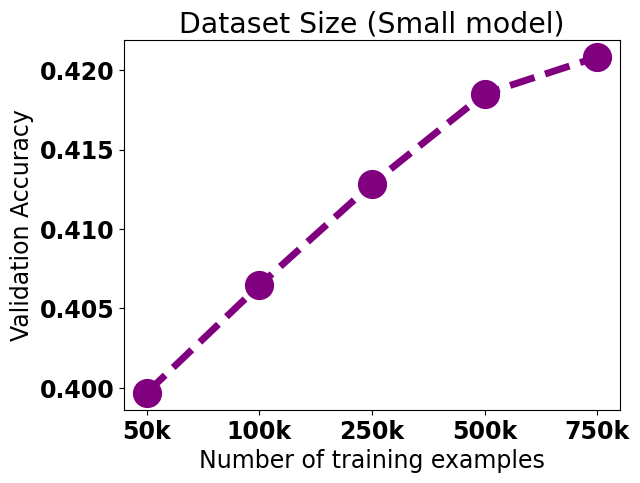

In [70]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family': 'normal', 'weight': 'bold', 'size': 17}
matplotlib.rc('font', **font)

fig, ax = plt.subplots()
ax.plot([x.cpu() for x in max_val_accs_dset],  marker='o', markersize=20, linestyle='--', color='purple', linewidth=5)
ax.set_title("Dataset Size (Small model)")
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(['50k', '100k', '250k', '500k', '750k'])
ax.set_xlabel("Number of training examples")
ax.set_ylabel("Validation Accuracy")
plt.savefig("scaling_dset_size.png", bbox_inches="tight")

## Compare the effects of context size

In [33]:
train_df = df.query("dataset == 'train'")
val_df = df.query("dataset == 'val'")

context_sizes = [3, 6, 9, 12]
max_val_accs_ctx = []
for context_size in context_sizes:
    print(f"CURRENT CONTEXT SIZE: {context_size}")
    X_train = np.lib.stride_tricks.sliding_window_view(train_df['action_token'].map(list(vocab).index), (context_size,))
    train_loader = torch.utils.data.DataLoader(
        list(zip(X_train[:-1], X_train[1:, -1])),
        batch_size = batch_size,
        shuffle = True
    )
    
    X_val = np.lib.stride_tricks.sliding_window_view(val_df['action_token'].map(list(vocab).index), (context_size,))
    val_loader = torch.utils.data.DataLoader(
        list(zip(X_val[:-1], X_val[1:, -1])),
        batch_size = batch_size,
        shuffle = True
    )

    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    print(device)

    model = BasicTransformer(len(vocab), 50, 2, 500, 1, 0.0).to(device=device)
    #model = BasicTransformer(len(vocab), 50, 10, 100, 8, 0.0).to(device=device)

    save_folder = f'checkpoints/ctx_s_{context_size}'
    os.mkdir(save_folder)

    train_losses, train_accs, val_losses, val_accs = train(model, device, train_loader, val_loader, len(X_train[:-1]), len(X_val[:-1]), n_epochs=6, save_name=os.path.join(save_folder, f'model_ctx_s_{context_size}'))
    max_val_accs_ctx.append(max(val_accs))

/home/daniel/miniconda3/envs/csc413/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


CURRENT CONTEXT SIZE: 3
cuda


100%|██████████| 2938/2938 [00:03<00:00, 930.42it/s]


Epoch 0, iter 23382, train_loss: 3.457358320105444, train_acc: 0.37732911109924316, val_loss: 2.7457657472222254, val_acc: 0.41024768352508545


100%|██████████| 2938/2938 [00:03<00:00, 948.41it/s]


Epoch 1, iter 23382, train_loss: 2.692946883576959, train_acc: 0.4099379777908325, val_loss: 2.6642868952575878, val_acc: 0.4135352075099945


100%|██████████| 2938/2938 [00:03<00:00, 949.51it/s]


Epoch 2, iter 23382, train_loss: 2.6250179228276083, train_acc: 0.413086861371994, val_loss: 2.6344681646322377, val_acc: 0.4158226251602173


100%|██████████| 2938/2938 [00:03<00:00, 930.85it/s]


Epoch 3, iter 23382, train_loss: 2.589477644450201, train_acc: 0.41500213742256165, val_loss: 2.6158391445002804, val_acc: 0.4173333942890167


100%|██████████| 2938/2938 [00:03<00:00, 944.10it/s]


Epoch 4, iter 23382, train_loss: 2.567070326816535, train_acc: 0.41685324907302856, val_loss: 2.606836964963974, val_acc: 0.417471706867218


100%|██████████| 2938/2938 [00:03<00:00, 947.02it/s]


Epoch 5, iter 23382, train_loss: 2.55189773538504, train_acc: 0.41815903782844543, val_loss: 2.600840377758927, val_acc: 0.4194718897342682
CURRENT CONTEXT SIZE: 6
cuda


100%|██████████| 2938/2938 [00:03<00:00, 928.41it/s]


Epoch 0, iter 23382, train_loss: 3.4422448616971635, train_acc: 0.37824881076812744, val_loss: 2.7387944358883463, val_acc: 0.4111863970756531


100%|██████████| 2938/2938 [00:03<00:00, 941.34it/s]


Epoch 1, iter 23382, train_loss: 2.688742622604383, train_acc: 0.4101080298423767, val_loss: 2.6602504997126823, val_acc: 0.414048433303833


100%|██████████| 2938/2938 [00:03<00:00, 945.24it/s]


Epoch 2, iter 23382, train_loss: 2.620573006098106, train_acc: 0.4137100279331207, val_loss: 2.6320581026755683, val_acc: 0.4161231517791748


100%|██████████| 2938/2938 [00:03<00:00, 922.01it/s]


Epoch 3, iter 23382, train_loss: 2.5844386332498606, train_acc: 0.4159313440322876, val_loss: 2.6125586638651876, val_acc: 0.4187617599964142


100%|██████████| 2938/2938 [00:03<00:00, 937.93it/s]


Epoch 4, iter 23382, train_loss: 2.560530564036772, train_acc: 0.4183945953845978, val_loss: 2.6002598370395607, val_acc: 0.4196873903274536


100%|██████████| 2938/2938 [00:03<00:00, 943.88it/s]


Epoch 5, iter 23382, train_loss: 2.5440404452960266, train_acc: 0.4195266664028168, val_loss: 2.5927895330262882, val_acc: 0.4205811321735382
CURRENT CONTEXT SIZE: 9
cuda


100%|██████████| 2938/2938 [00:03<00:00, 929.93it/s]


Epoch 0, iter 23382, train_loss: 3.4455833798060107, train_acc: 0.37852299213409424, val_loss: 2.7443734404686118, val_acc: 0.41014620661735535


100%|██████████| 2938/2938 [00:03<00:00, 944.19it/s]


Epoch 1, iter 23382, train_loss: 2.6886826247912397, train_acc: 0.4100802540779114, val_loss: 2.6598472611444834, val_acc: 0.41466814279556274


100%|██████████| 2938/2938 [00:03<00:00, 912.58it/s]


Epoch 2, iter 23382, train_loss: 2.6175000295903335, train_acc: 0.4137932062149048, val_loss: 2.624196056040718, val_acc: 0.41617903113365173


100%|██████████| 2938/2938 [00:03<00:00, 931.63it/s]


Epoch 3, iter 23382, train_loss: 2.580893581059968, train_acc: 0.41603460907936096, val_loss: 2.608821429083995, val_acc: 0.4191794693470001


100%|██████████| 2938/2938 [00:03<00:00, 945.09it/s]


Epoch 4, iter 23382, train_loss: 2.5571789560168305, train_acc: 0.4175261855125427, val_loss: 2.597517890253385, val_acc: 0.4205094575881958


100%|██████████| 2938/2938 [00:03<00:00, 909.16it/s]


Epoch 5, iter 23382, train_loss: 2.5398250715979946, train_acc: 0.419437438249588, val_loss: 2.586401845988487, val_acc: 0.420211523771286
CURRENT CONTEXT SIZE: 12
cuda


100%|██████████| 2937/2937 [00:03<00:00, 915.36it/s]


Epoch 0, iter 23381, train_loss: 3.438610158261922, train_acc: 0.37874636054039, val_loss: 2.7441485551980875, val_acc: 0.4104252755641937


100%|██████████| 2937/2937 [00:03<00:00, 936.20it/s]


Epoch 1, iter 23381, train_loss: 2.689311320290921, train_acc: 0.4103144705295563, val_loss: 2.659112210699113, val_acc: 0.41461753845214844


100%|██████████| 2937/2937 [00:03<00:00, 918.39it/s]


Epoch 2, iter 23381, train_loss: 2.6189467230526753, train_acc: 0.4136398136615753, val_loss: 2.6281502091401605, val_acc: 0.4161284565925598


100%|██████████| 2937/2937 [00:03<00:00, 911.56it/s]


Epoch 3, iter 23381, train_loss: 2.5800743679775766, train_acc: 0.41621133685112, val_loss: 2.6082758030844335, val_acc: 0.41894811391830444


100%|██████████| 2937/2937 [00:03<00:00, 934.11it/s]


Epoch 4, iter 23381, train_loss: 2.556243691451127, train_acc: 0.4178486168384552, val_loss: 2.5945916408416076, val_acc: 0.4195120334625244


100%|██████████| 2937/2937 [00:03<00:00, 913.12it/s]

Epoch 5, iter 23381, train_loss: 2.5378266583378815, train_acc: 0.41913706064224243, val_loss: 2.586115050283386, val_acc: 0.4202462136745453


In [34]:
max_val_accs

[tensor(0.4195, device='cuda:0'),
 tensor(0.4206, device='cuda:0'),
 tensor(0.4205, device='cuda:0'),
 tensor(0.4202, device='cuda:0')]

In [ ]:
# max_val_accs = [tensor(0.4195, device='cuda:0'),
#  tensor(0.4206, device='cuda:0'),
#  tensor(0.4205, device='cuda:0'),
#  tensor(0.4202, device='cuda:0')]

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

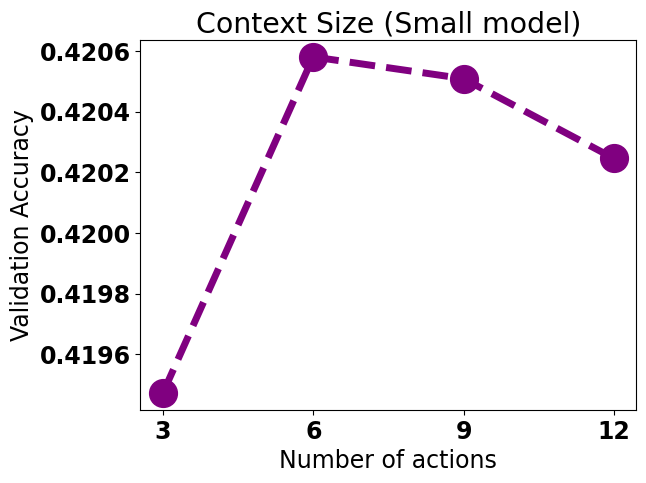

In [69]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family': 'normal', 'weight': 'bold', 'size': 17}
matplotlib.rc('font', **font)

fig, ax = plt.subplots()
ax.plot([x.cpu() for x in max_val_accs_ctx], marker='o', markersize=20, linestyle='--', color='purple', linewidth=5)
ax.set_title("Context Size (Small model)")
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['3', '6', '9', '12'])
ax.set_xlabel("Number of actions")
ax.set_ylabel("Validation Accuracy")
plt.savefig("scaling_ctx.png", bbox_inches="tight")

## Compare the effects of number of parameters

In [62]:
len(vocab)

3015

In [38]:
train_df = df.query("dataset == 'train'")
val_df = df.query("dataset == 'val'")

X_train = np.lib.stride_tricks.sliding_window_view(train_df['action_token'].map(list(vocab).index), (context_size,))
train_loader = torch.utils.data.DataLoader(
    list(zip(X_train[:-1], X_train[1:, -1])),
    batch_size = batch_size,
    shuffle = True
)

X_val = np.lib.stride_tricks.sliding_window_view(val_df['action_token'].map(list(vocab).index), (context_size,))
val_loader = torch.utils.data.DataLoader(
    list(zip(X_val[:-1], X_val[1:, -1])),
    batch_size = batch_size,
    shuffle = True
)


params = [(2, 1), (5, 2), (5, 4), (10, 8)]
total_params = []
max_val_accs_params = []
for param in params:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    print(device)

    model = BasicTransformer(len(vocab), 50, param[0], 500, param[1], 0.0).to(device=device)
    cur_param_num = sum(p.numel() for p in model.parameters())
    total_params.append(cur_param_num)
    print(f"CURRENT Params: {params} {cur_param_num}")
    #model = BasicTransformer(len(vocab), 50, 10, 100, 8, 0.0).to(device=device)

    save_folder = f'checkpoints/params_s_{total_params}'
    os.mkdir(save_folder)

    train_losses, train_accs, val_losses, val_accs = train(model, device, train_loader, val_loader, len(X_train[:-1]), len(X_val[:-1]), n_epochs=6, save_name=os.path.join(save_folder, f'model_param_s_{total_params}'))
    max_val_accs_params.append(max(val_accs))

/home/daniel/miniconda3/envs/csc413/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


cuda
CURRENT Params: [(2, 1), (5, 2), (5, 4), (10, 8)] 365565


100%|██████████| 2937/2937 [00:03<00:00, 913.09it/s]


Epoch 0, iter 23381, train_loss: 3.4355744374409687, train_acc: 0.37911659479141235, val_loss: 2.742658957641142, val_acc: 0.41077640652656555


100%|██████████| 2937/2937 [00:03<00:00, 935.70it/s]


Epoch 1, iter 23381, train_loss: 2.6896981340005093, train_acc: 0.4100992679595947, val_loss: 2.6672692982810347, val_acc: 0.4153410792350769


100%|██████████| 2937/2937 [00:03<00:00, 941.04it/s]


Epoch 2, iter 23381, train_loss: 2.620472378596376, train_acc: 0.4137895107269287, val_loss: 2.626887312380278, val_acc: 0.4172030985355377


100%|██████████| 2937/2937 [00:03<00:00, 948.97it/s]


Epoch 3, iter 23381, train_loss: 2.5813286531308544, train_acc: 0.4163396656513214, val_loss: 2.6069870382334286, val_acc: 0.4188629984855652


100%|██████████| 2937/2937 [00:03<00:00, 924.41it/s]


Epoch 4, iter 23381, train_loss: 2.555471149131692, train_acc: 0.4177764654159546, val_loss: 2.594432759252502, val_acc: 0.420395165681839


100%|██████████| 2937/2937 [00:03<00:00, 912.02it/s]


Epoch 5, iter 23381, train_loss: 2.5369357725627752, train_acc: 0.4189593195915222, val_loss: 2.587264473883928, val_acc: 0.4201398193836212
cuda
CURRENT Params: [(2, 1), (5, 2), (5, 4), (10, 8)] 426515


100%|██████████| 2937/2937 [00:04<00:00, 659.49it/s]


Epoch 0, iter 23381, train_loss: 3.4638903341547853, train_acc: 0.3769152760505676, val_loss: 2.744785602700763, val_acc: 0.41234052181243896


100%|██████████| 2937/2937 [00:04<00:00, 684.03it/s]


Epoch 1, iter 23381, train_loss: 2.693166040343279, train_acc: 0.4099937081336975, val_loss: 2.6557195529184416, val_acc: 0.41570284962654114


100%|██████████| 2937/2937 [00:04<00:00, 654.89it/s]


Epoch 2, iter 23381, train_loss: 2.6127494091983734, train_acc: 0.4145406484603882, val_loss: 2.614716820502549, val_acc: 0.4184373915195465


100%|██████████| 2937/2937 [00:04<00:00, 663.87it/s]


Epoch 3, iter 23381, train_loss: 2.5676705838983263, train_acc: 0.41750645637512207, val_loss: 2.5898994836914406, val_acc: 0.4207569360733032


100%|██████████| 2937/2937 [00:04<00:00, 656.98it/s]


Epoch 4, iter 23381, train_loss: 2.5387892091576605, train_acc: 0.419808030128479, val_loss: 2.585933966136604, val_acc: 0.420725017786026


100%|██████████| 2937/2937 [00:04<00:00, 667.12it/s]


Epoch 5, iter 23381, train_loss: 2.5184462152449836, train_acc: 0.42147737741470337, val_loss: 2.572356293913374, val_acc: 0.42194864153862
cuda
CURRENT Params: [(2, 1), (5, 2), (5, 4), (10, 8)] 548415


100%|██████████| 2937/2937 [00:06<00:00, 438.65it/s]


Epoch 0, iter 23381, train_loss: 3.4916798525709862, train_acc: 0.3721838891506195, val_loss: 2.7617921288175, val_acc: 0.40879732370376587


100%|██████████| 2937/2937 [00:06<00:00, 438.19it/s]


Epoch 1, iter 23381, train_loss: 2.7082033270842443, train_acc: 0.40905678272247314, val_loss: 2.6615407584190045, val_acc: 0.4150218665599823


100%|██████████| 2937/2937 [00:06<00:00, 423.86it/s]


Epoch 2, iter 23381, train_loss: 2.621611062620047, train_acc: 0.4136277735233307, val_loss: 2.6172599933323584, val_acc: 0.41833096742630005


100%|██████████| 2937/2937 [00:06<00:00, 427.58it/s]


Epoch 3, iter 23381, train_loss: 2.5727543955072356, train_acc: 0.4169384241104126, val_loss: 2.5924102535936187, val_acc: 0.42005470395088196


100%|██████████| 2937/2937 [00:06<00:00, 439.89it/s]


Epoch 4, iter 23381, train_loss: 2.540667770202684, train_acc: 0.41957277059555054, val_loss: 2.5781903348896105, val_acc: 0.42099103331565857


100%|██████████| 2937/2937 [00:06<00:00, 431.13it/s]


Epoch 5, iter 23381, train_loss: 2.5175869466148906, train_acc: 0.4217246472835541, val_loss: 2.5665103313993507, val_acc: 0.4225977063179016
cuda
CURRENT Params: [(2, 1), (5, 2), (5, 4), (10, 8)] 792215


100%|██████████| 2937/2937 [00:11<00:00, 255.54it/s]


Epoch 0, iter 23381, train_loss: 3.699819935254772, train_acc: 0.3483169972896576, val_loss: 2.792076503130543, val_acc: 0.40785035490989685


100%|██████████| 2937/2937 [00:11<00:00, 252.07it/s]


Epoch 1, iter 23381, train_loss: 2.7482456384847826, train_acc: 0.40628206729888916, val_loss: 2.679636039983914, val_acc: 0.4133619964122772


100%|██████████| 2937/2937 [00:11<00:00, 248.86it/s]


Epoch 2, iter 23381, train_loss: 2.6506178411179726, train_acc: 0.4126039743423462, val_loss: 2.6284567898213558, val_acc: 0.41728824377059937


100%|██████████| 2937/2937 [00:11<00:00, 256.68it/s]


Epoch 3, iter 23381, train_loss: 2.5957526907501327, train_acc: 0.41572216153144836, val_loss: 2.5994633087951144, val_acc: 0.4190013110637665


100%|██████████| 2937/2937 [00:11<00:00, 254.89it/s]


Epoch 4, iter 23381, train_loss: 2.557531666686336, train_acc: 0.41881629824638367, val_loss: 2.583050949580823, val_acc: 0.42188480496406555


100%|██████████| 2937/2937 [00:11<00:00, 252.43it/s]

Epoch 5, iter 23381, train_loss: 2.5304134035838546, train_acc: 0.4205898940563202, val_loss: 2.567770136429576, val_acc: 0.41940563917160034


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

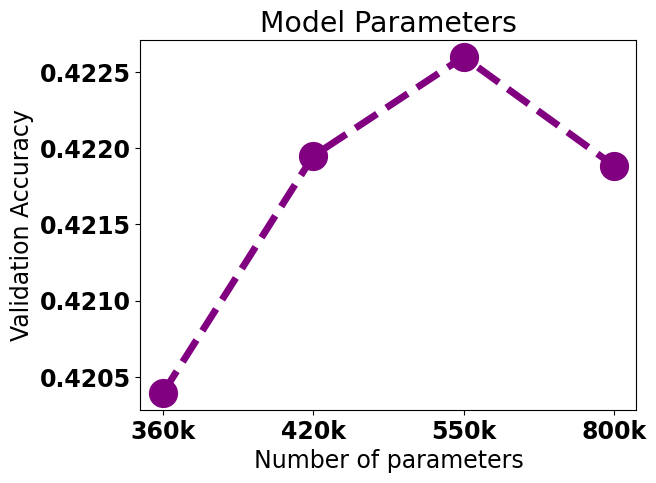

In [67]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family': 'normal', 'weight': 'bold', 'size': 17}
matplotlib.rc('font', **font)

fig, ax = plt.subplots()
ax.plot([x.cpu() for x in max_val_accs_params], marker='o', markersize=20, linestyle='--', color='purple', linewidth=5)
ax.set_title("Model Parameters")
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['360k', '420k', '550k', '800k'])
ax.set_xlabel("Number of parameters")
ax.set_ylabel("Validation Accuracy")
plt.savefig("scaling_params.png", bbox_inches="tight")